# PCA and SVR Analysis
## Using the data on electricity production in Denmark
Figure out the largest contributing factors to CO2 emissions using PCA

In [1]:
import pandas as pd
from pandas import DataFrame


In [2]:
h_start = 0    # start of header names, inclusive
h_end = 20     # end of header names, exclusive
d_start = 22   # start of data values,
dates = [0,]   # Column zero is a date and Pandas must interpret it as a date

In [3]:
with open("20161208_onlinedata.csv", encoding="latin1") as f:
    data_fields = f.readlines()[h_start:h_end]
    f.seek(0,0)
    data_values = pd.read_csv(f, skiprows=d_start-1, sep=';', infer_datetime_format=True, parse_dates=dates)

In [4]:
# Clean leading and trailing spaces, tabs, newlines
# split on first space only, and then only take the text field -> ['first header name', 'second header name']
headers = [d.strip() for d in data_fields]
headers = [h.split(" ", maxsplit=1)[1] for h in headers] 

In [5]:
# Insert the name of the time column
headers.insert(0, "Dato og tid")

In [6]:
# Drop the last empty column
data_values = data_values.drop('Unnamed: 21', axis=1)  # We drop column with name 21, on the 1st axis (columns)

In [7]:
# Make a new final object
df = data_values.copy(deep=True)

# Set the header names
df.columns = headers

# Set the Date to be the index
df = df.set_index(df.columns[0])

## We now have a final dataset
Now, begin to make it ready for PCA

In [8]:
# Create a df to do PCA on
df2 = df.copy(deep=True)

In [9]:
# Pop out the CO2 column and save it
CO2 = df2.pop('CO2 udledning')

In [10]:
# Pop off and discard the two unusable columns
df2.pop('Vindhastighed i Malling');
df2.pop('Temperatur i Malling');

### Import PCA model

In [11]:
import numpy as np
from sklearn.decomposition import PCA

In [12]:
pca_model = PCA(n_components=1)

Attempt to make a model with just one component, i.e. make 1 new variable by combining the 20 old variables into 1 new variable

In [13]:
pca_model.fit(df2)

PCA(n_components=1)

Show how many percent of total variance in the data can be explained with just the 1 component

In [14]:
print(pca_model.explained_variance_ratio_)

[0.79257213]


In [15]:
z = zip(pca_model.components_.T[:,0], df2.columns.T)
list(z)

[(0.12597996986359525, 'Centrale kraftværker DK1'),
 (0.012639045915224245, 'Centrale kraftværker DK2'),
 (0.059873862966092824, 'Decentrale kraftværker DK1'),
 (0.01481577297282811, 'Decentrale kraftværker DK2'),
 (-0.44167102846258777, 'Vindmøller DK1'),
 (-0.07026999074319044, 'Vindmøller DK2'),
 (0.6743662578385146, 'Udveksling Jylland-Norge'),
 (-0.06515162528706121, 'Udveksling Jylland-Sverige'),
 (-0.15354756286331547, 'Udveksling Jylland-Tyskland'),
 (0.3009366106917083, 'Udveksling Sjælland-Sverige'),
 (-0.07732449721545338, 'Udveksling Sjælland-Tyskland'),
 (0.001093797833095818, 'Udveksling Bornholm-Sverige'),
 (0.009799592537681373, 'Udveksling Fyn-Sjaelland'),
 (-0.06904898350365901, 'Havmøller DK'),
 (-0.4428941383377205, 'Landmøller DK'),
 (-0.00042083450054026346, 'Solceller DK1'),
 (-3.396703926453231e-05, 'Solceller DK2')]

Perform the transformation, i.e. make the new variable by applying weights to each column and taking sum

In [16]:
x = pca_model.fit(df2).transform(df2)

Make a small new dataset with the CO2 data and the new PCA variable

In [17]:
cmp = CO2.to_frame()  # Make the Series object into a DataFrame
cmp["PCA"] = x[:,0]   # Make a new column with the PCA variable

In [18]:
cmp

,CO2 udledning,PCA
Dato og tid,,
2016-12-08 00:00:00,190,-1771.556285
2016-12-08 00:05:00,184,-1815.747534
2016-12-08 00:10:00,180,-1823.303024
2016-12-08 00:15:00,175,-1813.974267
2016-12-08 00:20:00,170,-1833.460103
...,...,...
2016-12-08 23:35:00,292,33.259697
2016-12-08 23:40:00,294,46.548923
2016-12-08 23:45:00,297,66.868377


### Look at the results
Compare the CO2 value to the 1 new variable.
We plot on different axes, as the two series are not equally scaled

Use seaborn to make it look nicer

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

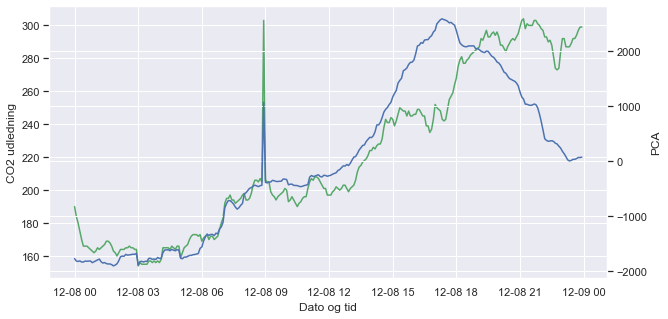

In [20]:
plt.figure(figsize=(10,5))
sns.lineplot(data=cmp['CO2 udledning'], color="g");
ax2 = plt.twinx()
sns.lineplot(data=cmp['PCA'], color="b", ax=ax2);

This shows how the new single variable explains most of the variation in CO2 emissions.

# SVR Regression model

In [72]:
from sklearn.svm import SVR

In [56]:
SVR?

In [73]:
svr_rbf = SVR(kernel='rbf')
svr_lin = SVR(kernel='linear')
svr_poly = SVR(kernel='poly')

### Set up independent variable matrix

In [74]:
X = df.drop(
    columns=['Vindmøller DK1', 
             'Vindmøller DK2', 
             'Temperatur i Malling', 
             'Vindhastighed i Malling', 
             'Havmøller DK', 
             'Landmøller DK',
             'Solceller DK1',
             'Solceller DK2']
)

### Set up dependent variable

In [75]:
y = X.pop('CO2 udledning')

### Fit the models on the energy production data

In [76]:
svr_rbf.fit(X,y)
svr_lin.fit(X,y)
svr_poly.fit(X,y)

SVR(kernel='poly')

### Set up DataFrame to store comparisons

In [77]:
y_data = y.to_frame()

### In-sample prediction

In [78]:
yhat_rbf = svr_rbf.predict(X)
yhat_lin = svr_lin.predict(X)
yhat_poly = svr_poly.predict(X)

Save the predicted values in the pandas array

In [79]:
y_data["y rbf fit"] = yhat_rbf   # Make a new column with the SVR variable
y_data["y lin fit"] = yhat_lin
y_data["y poly fit"] = yhat_poly

In [80]:
y_data

,CO2 udledning,y rbf fit,y lin fit,y poly fit
Dato og tid,,,,
2016-12-08 00:00:00,190,171.481458,194.922431,171.326255
2016-12-08 00:05:00,184,173.604700,190.030728,175.392295
2016-12-08 00:10:00,180,174.732142,183.697624,177.409074
2016-12-08 00:15:00,175,174.900000,178.719788,178.879199
2016-12-08 00:20:00,170,174.725156,172.615635,179.008417
...,...,...,...,...
2016-12-08 23:35:00,292,188.507406,293.616533,193.710268
2016-12-08 23:40:00,294,188.516874,294.100272,193.730870
2016-12-08 23:45:00,297,188.063583,288.452679,193.108591


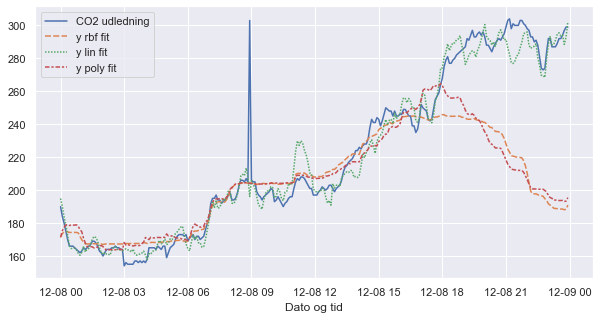

In [81]:
plt.figure(figsize=(10,5))
sns.lineplot(data=y_data);

The plot shows that a linear model fits the data best.
Possibly, the one large outlier affects the RBF and Poly models more than the linear model.

### Find out something more about the linear model

Regression coefficients

In [88]:
svr_lin.coef_

array([[ 1.56649847e-01,  1.08930240e-01,  1.28524788e-01,
        -1.67562331e-02,  3.40426721e-02,  5.98768504e-02,
         2.09232413e-04, -9.67824319e-02, -9.70612859e-02,
         7.22001177e-01,  1.17920562e-01]])

In [89]:
svr_lin.score?

The score is the R^2: 96% of the variance in the data is explained by the model.

In [90]:
svr_lin.score(X,y)

0.9602532734483797